<a href="https://colab.research.google.com/github/Frank-Tsai-23026407/tensorflow-render/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Image Processing

就如同之前的作業一般，先將圖片調整好大小。使用的函式庫
* PIL
* cv2

In [ ]:
def image_preprocessing(img, img_size, background_color):
  width, height = img.size
  if width > height:
    result = Image.new(img.mode, (width, width), background_color)
    result.paste(img, (0, (width - height) // 2))

  elif width < height:
    result = Image.new(img.mode, (height, height), background_color)
    result.paste(img, ((height - width) // 2, 0))
  result = result.resize((224, 224))
  return result

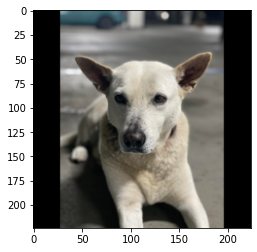

In [ ]:
from google.colab.patches import cv2_imshow
img_path = '/content/drive/MyDrive/medium/test4.jpg'

img = Image.open(img_path)
img = image_preprocessing(img, (224,224), (0, 0, 0))

img = np.uint8(img)

plt.imshow(img)
plt.show()

# Grad_CAM
> 觀察模型著重在哪部分

1. 將模型載近來
2. 選號要觀察的conv層
3. Gradient Descent來尋找各層比重
4. 相加起來
5. 將原圖也一起疊加出來一起看

In [ ]:
model = ResNet50(weights='imagenet')
#model.summary()
#tf.keras.utils.plot_model(model, to_file='LeNet.png')

In [ ]:
layer_name = 'conv5_block3_3_conv'

In [ ]:
img = np.array([img])
img = preprocess_input(img)

preds = model.predict(img)
y_pred = preds.argmax(-1)
y_pred_class = decode_predictions(preds, top=1)
print("預測指標為{0}，類別為{1}". format(y_pred[0], y_pred_class[0][0][1]))

class_index = y_pred[0]

預測指標為273，類別為dingo


In [ ]:
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output], name = 'Grad_CAM')

In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, class_index]

# conv_outputs.shape = (0, 7, 7, 2048)
output = conv_outputs[0]

# 計算各層的gradient
grads = tape.gradient(loss, conv_outputs)[0]

# 只取算出來是正，且grad是正的地方
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

# 在第0軸以及第1軸取平均
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

In [ ]:
# 將所有的layer乘上個別的weight之後相加起來
cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]
print(cam.shape)

(7, 7)


In [ ]:
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

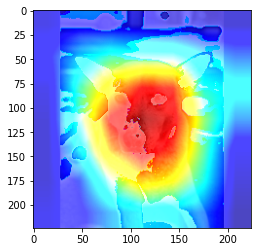

In [ ]:
output_image = cv2.addWeighted(cv2.cvtColor(img[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)


output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.show()